In [ ]:
import torch
from models.vq_autoencoder import SimpleVQAutoEncoder
from hydra.utils import instantiate
from hydra import compose, initialize_config_dir
import os


# Define the load function
def load_trained_model(checkpoint_path, cfg):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load encoder and decoder
    encoder_cls = instantiate(cfg.model.encoder)
    decoder_cls = instantiate(cfg.model.decoder)

    # Initialize model
    model = SimpleVQAutoEncoder(
        encoder=encoder_cls,
        decoder=decoder_cls,
        h_dim=cfg.model.h_dim,
        num_quantizers=cfg.model.num_quantizers,
        codebook_size=cfg.model.codebook_size,
    )
    model.to(device)

    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    print(f"Model loaded from {checkpoint_path}")

    return model


checkpoint_path = "out/checkpoint.pt"
# model_cfg = "config/train_autoencoder.yaml"
config_dir = "/data2/zijin/random/2024-SmallData-Project/config"  # Replace with the directory containing your config
config_name = "train_autoencoder"  # Replace with your configuration name

# Ensure Hydra initializes correctly in a notebook
if "HYDRA_CONFIG_PATH" not in os.environ:
    initialize_config_dir(config_dir=config_dir, job_name="notebook")

# Compose the configuration
cfg = compose(config_name=config_name)
trained_model = load_trained_model(checkpoint_path, cfg)

# Switch to evaluation mode
trained_model.eval()


/tmp/ipykernel_3790356/1756788372.py:39: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize_config_dir(config_dir=config_dir, job_name="notebook")
/data2/zijin/miniforge3/envs/small_data/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'train_autoencoder': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


Model loaded from out/checkpoint.pt


/tmp/ipykernel_3790356/1756788372.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


SimpleVQAutoEncoder(
  (encoder): ResNetEncoder(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNor

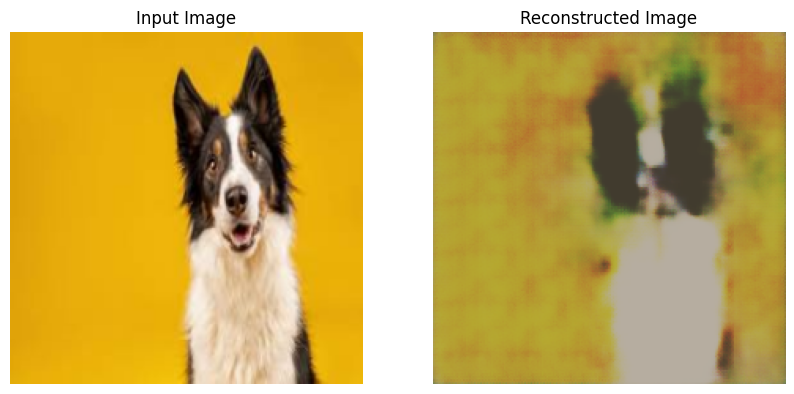

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms

# Path to the input image
input_image_path = "/data2/zijin/random/2024-SmallData-Project/testing_dataset/dog/images/05b151f72d.jpg"

# Load the image
input_image = Image.open(input_image_path).convert("RGB")

# Define ImageNet normalization parameters
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Define preprocessing (resize, to tensor, normalize)
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),  # Adjust size to 224x224
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    ]
)

# Preprocess the image
device = "cuda" if torch.cuda.is_available() else "cpu"
input_tensor = transform(input_image).unsqueeze(0).to(device)

# Pass the image through the trained model
with torch.no_grad():
    reconstructed_tensor = trained_model(input_tensor)[0]


# Reverse normalization for visualization
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(tensor.device)
    return tensor * std + mean


# Convert tensors back to images for visualization
def tensor_to_image(tensor):
    return transforms.ToPILImage()(tensor.squeeze().cpu().clamp(0, 1))


# Denormalize input and reconstructed tensors for visualization
input_tensor_denormalized = denormalize(input_tensor, imagenet_mean, imagenet_std)
reconstructed_tensor_denormalized = denormalize(
    reconstructed_tensor, imagenet_mean, imagenet_std
)

input_image_resized = tensor_to_image(input_tensor_denormalized)
reconstructed_image = tensor_to_image(reconstructed_tensor_denormalized)

# Plot input and output images
plt.figure(figsize=(10, 5))

# Input image
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(input_image_resized)
plt.axis("off")

# Reconstructed image
plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image)
plt.axis("off")

plt.show()


In [24]:
trained_model.get_latent_vector(input_tensor).shape

torch.Size([1, 49, 512])

In [ ]:
import os
import torch
from torchvision import datasets, transforms
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import numpy as np

# Define the dataset path
dataset_path = "/data2/zijin/random/2024-SmallData-Project/testing_dataset"

# Define ImageNet normalization parameters
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Define image transformations
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    ]
)

# Load dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

# Extract latent vectors
device = "cuda" if torch.cuda.is_available() else "cpu"
trained_model.to(device)
trained_model.eval()

latent_vectors = []
labels = []

with torch.no_grad():
    for images, targets in dataloader:
        images = images.to(device)
        # Get latent vectors from the model
        latent = trained_model.get_latent_vector(images)  # Shape: [batch_size, 49, 512]
        # Flatten the latent vectors
        latent = latent.reshape(latent.size(0), -1)  # Shape: [batch_size, 49*512]
        latent_vectors.append(latent.cpu())
        labels.extend(targets.numpy())

latent_vectors = torch.cat(latent_vectors).numpy()  # Shape: [num_samples, 49*512]
labels = np.array(labels)

# Clustering using KMeans
num_clusters = 9
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_assignments = kmeans.fit_predict(latent_vectors)

# Map clusters to ground truth classes
# Assign the most common ground truth label in each cluster
# Get label names from the dataset
label_names = dataset.classes  # List of class names indexed by the numeric label

# Map clusters to ground truth classes and store cluster names as predicted labels
cluster_to_label = {}
cluster_to_name = {}  # Map cluster IDs to string names
for cluster_id in range(num_clusters):
    indices = np.where(cluster_assignments == cluster_id)[0]
    cluster_labels = labels[indices]
    if len(cluster_labels) > 0:
        # Find the most frequent label in this cluster
        majority_label = np.bincount(cluster_labels).argmax()
        cluster_to_label[cluster_id] = majority_label
        # Assign a name to the cluster based on majority label and real label name
        cluster_to_name[cluster_id] = (
            f"Cluster_{cluster_id}_Label_{label_names[majority_label]}"
        )

# Assign predicted labels based on cluster names
predicted_labels = np.array(
    [cluster_to_label[cluster] for cluster in cluster_assignments]
)

# Map numeric predicted labels to their real names
predicted_label_names = [label_names[label] for label in predicted_labels]

# Calculate accuracy
real_label_names = [
    label_names[label] for label in labels
]  # Map ground truth labels to their names
accuracy = accuracy_score(real_label_names, predicted_label_names)
print(f"Clustering Accuracy: {accuracy:.4f}")

# Save clusters
output_path = "/data2/zijin/random/cluster_results"
os.makedirs(output_path, exist_ok=True)

for cluster_id in range(num_clusters):
    cluster_indices = np.where(cluster_assignments == cluster_id)[0]
    cluster_folder = os.path.join(
        output_path, cluster_to_name[cluster_id]
    )  # Use cluster name as folder name
    os.makedirs(cluster_folder, exist_ok=True)

    for idx in cluster_indices:
        src = dataset.imgs[idx][0]  # Get image path from dataset
        dst = os.path.join(cluster_folder, os.path.basename(src))
        os.symlink(src, dst)  # Creates symbolic links for grouped images

print(f"Clusters saved to {output_path}")


Clustering Accuracy: 0.3149
Clusters saved to /data2/zijin/random/cluster_results


In [46]:
trained_model.encoder

ResNetEncoder(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score

# Paths to datasets
train_dir = "/data2/zijin/random/2024-SmallData-Project/training_dataset"
test_dir = "/data2/zijin/random/2024-SmallData-Project/testing_dataset"

# Hyperparameters
batch_size = 32
num_epochs = 30
learning_rate = 0.001
freeze_encoder = True  # Set to False to fine-tune the encoder

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)


# Define the model by reusing the existing encoder
class ResNet18_w_trained_conv_layers(nn.Module):
    def __init__(self, existing_encoder, num_classes, freeze_encoder):
        super(ResNet18_w_trained_conv_layers, self).__init__()
        self.encoder = existing_encoder  # Reuse the existing encoder
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Add average pooling
        self.classifier = nn.Linear(512, num_classes)  # Classifier head

        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.encoder(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


class ResNet18_w_trained_conv_layers_MLP(nn.Module):
    def __init__(self, existing_encoder, num_classes, freeze_encoder):
        super(ResNet18_w_trained_conv_layers_MLP, self).__init__()
        self.encoder = existing_encoder  # Reuse the existing encoder
        self.mlp = nn.Sequential(  # Add an MLP layer
            nn.Conv2d(512, 256, kernel_size=1),  # Reduce channels from 512 to 256
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=1),  # Project back to 512 channels
            nn.ReLU(inplace=True),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Add average pooling
        self.classifier = nn.Linear(512, num_classes)  # Classifier head

        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.encoder(x)  # Output shape: [batch_size, 512, H, W]
        x = self.mlp(
            x
        )  # MLP applied to conv features, output shape: [batch_size, 512, H, W]
        x = self.avgpool(x)  # Pooling reduces spatial dimensions to 1x1
        x = torch.flatten(x, 1)  # Flatten to [batch_size, 512]
        x = self.classifier(x)  # Output logits for classification
        return x


# Assuming `trained_model` is already loaded and has an `encoder` property
# Example: trained_model = torch.load('/path/to/saved_model.pth')
num_classes = len(train_dataset.classes)
resnet18 = models.resnet18(pretrained=False)
first_four_layers = nn.Sequential(*list(resnet18.children())[:-2])
model = ResNet18_w_trained_conv_layers(
    existing_encoder=trained_model.encoder,
    num_classes=num_classes,
    freeze_encoder=freeze_encoder,
)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate
)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    print(
        f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%"
    )

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (114688x7 and 25088x1024)